In [414]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

In [415]:
def importImage(path):
    images = []
    folder_path = path
    file_names = os.listdir(folder_path)
    i = 0
    for file_name in file_names:
        i+=1
        file_path = os.path.join(folder_path, file_name)
        image = cv2.imread(file_path)
        images.append(image)
        if i == 24 : break
    return images


In [416]:
imageRed = importImage("traffic_light_data/train/red")
imageYellow = importImage("traffic_light_data/train/yellow")
imageGreen = importImage("traffic_light_data/train/green")

In [417]:
def displayImage(images):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        plt.subplot(12, 12, i+1)
        bgr_image = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
        plt.imshow(bgr_image)
    plt.show()


In [418]:
def resizeImage(images):
    images_resize = []
    for image in images:
        image_resize = cv2.resize(image,(200,400))
        images_resize.append(image_resize)
    return images_resize

In [419]:
imageRed_resize = resizeImage(imageRed)
imageYellow_resize = resizeImage(imageYellow)
imageGreen_resize = resizeImage(imageGreen)

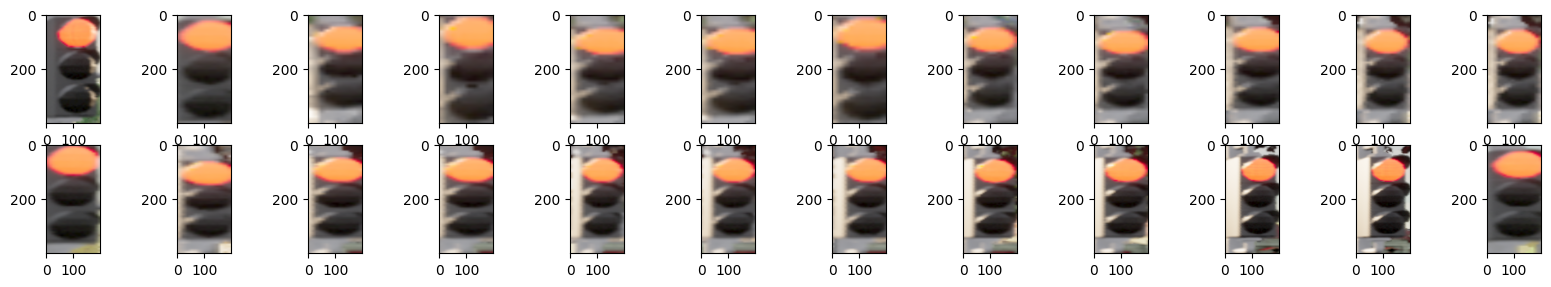

In [420]:
displayImage(imageRed_resize)

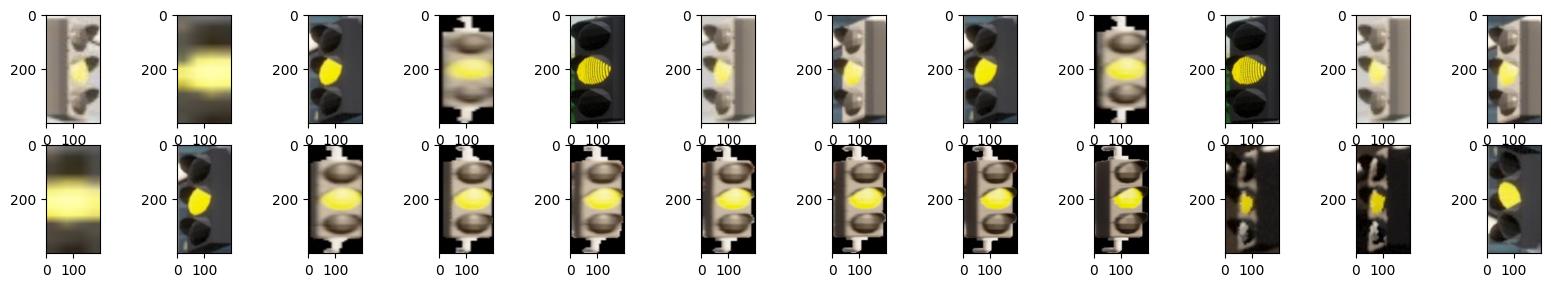

In [421]:
displayImage(imageYellow_resize)

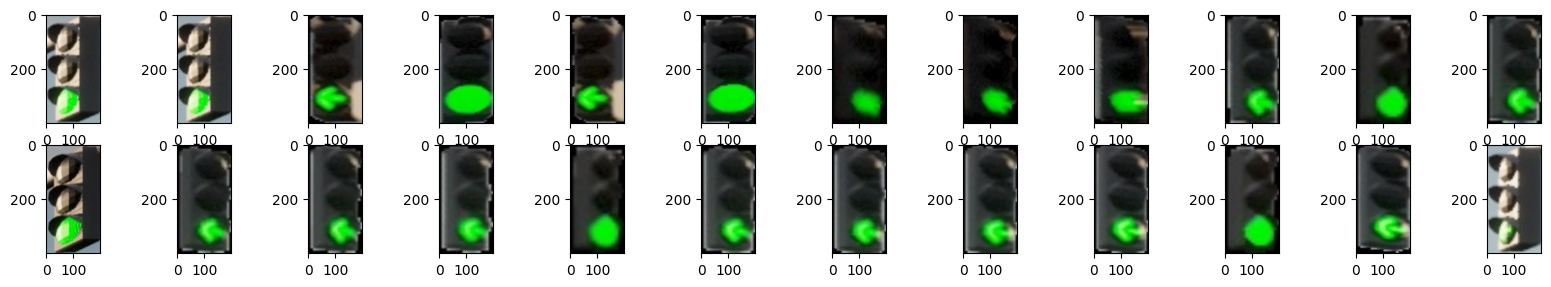

In [422]:
displayImage(imageGreen_resize)

In [423]:
def noiseRemoval(images):
    images_noise = []
    for image in images:
        image_noise = cv2.GaussianBlur(image, (5, 5), 0)
        images_noise.append(image_noise)
    return images_noise

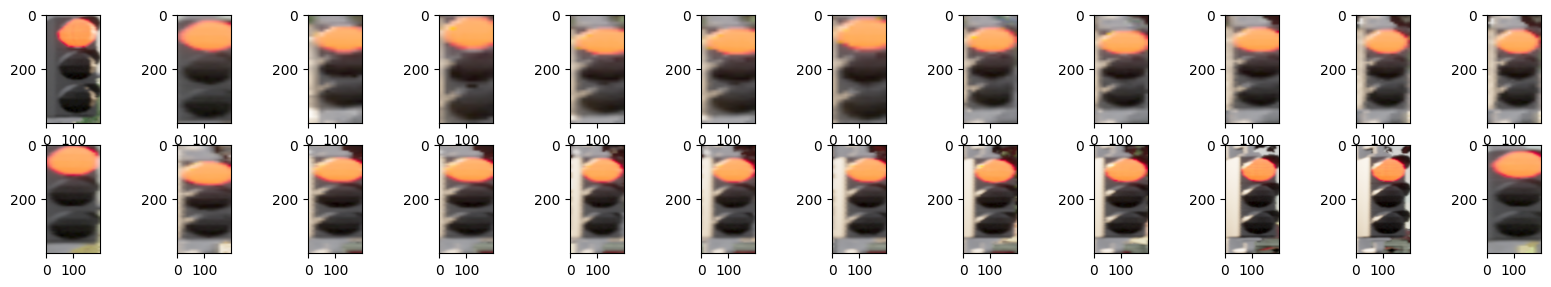

In [424]:
blurRed = noiseRemoval(imageRed_resize)
displayImage(blurRed)

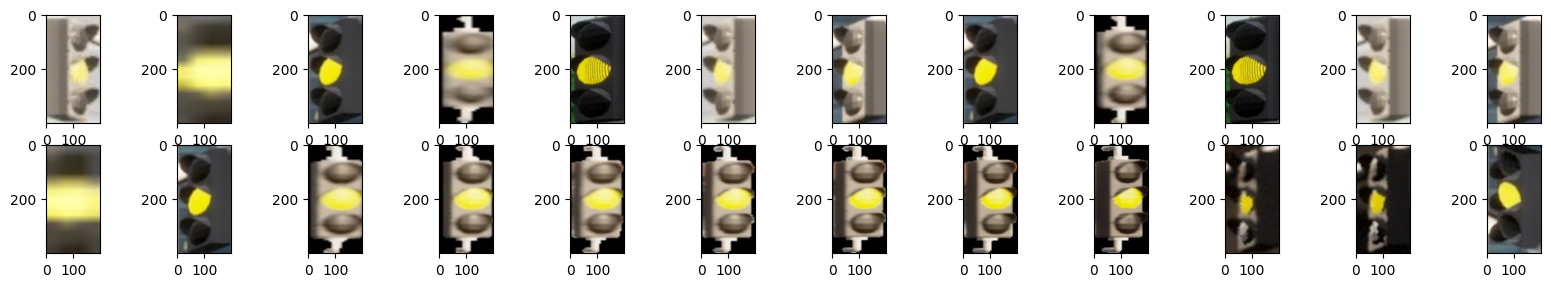

In [425]:
blurYellow = noiseRemoval(imageYellow_resize)
displayImage(blurYellow)

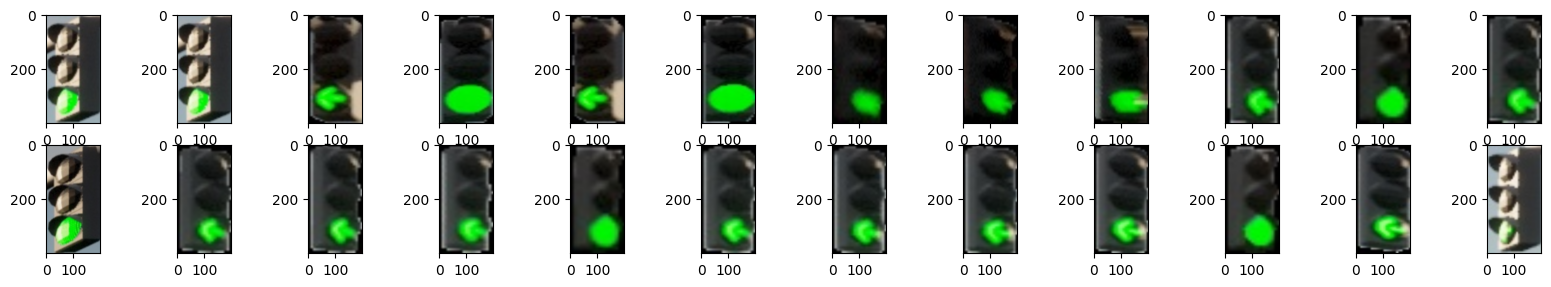

In [426]:
blurGreen = noiseRemoval(imageGreen_resize)
displayImage(blurGreen)

In [427]:
def contrastEnhancement(images):
    images_contrast = []
    for image in images:
        image_lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        lab_planes = cv2.split(image_lab)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        lab_planes = list(lab_planes)
        lab_planes[0] = clahe.apply(lab_planes[0])
        lab_planes = tuple(lab_planes)
        image_lab = cv2.merge(lab_planes)
        image_contrast = cv2.cvtColor(image_lab, cv2.COLOR_LAB2BGR)
        images_contrast.append(image_contrast)
    return images_contrast


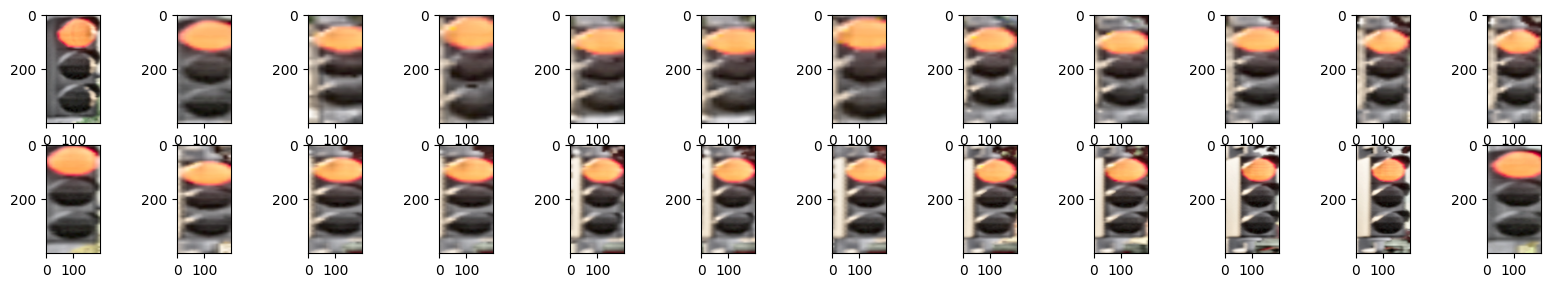

In [428]:
contrastRed = contrastEnhancement(blurRed)
displayImage(contrastRed)

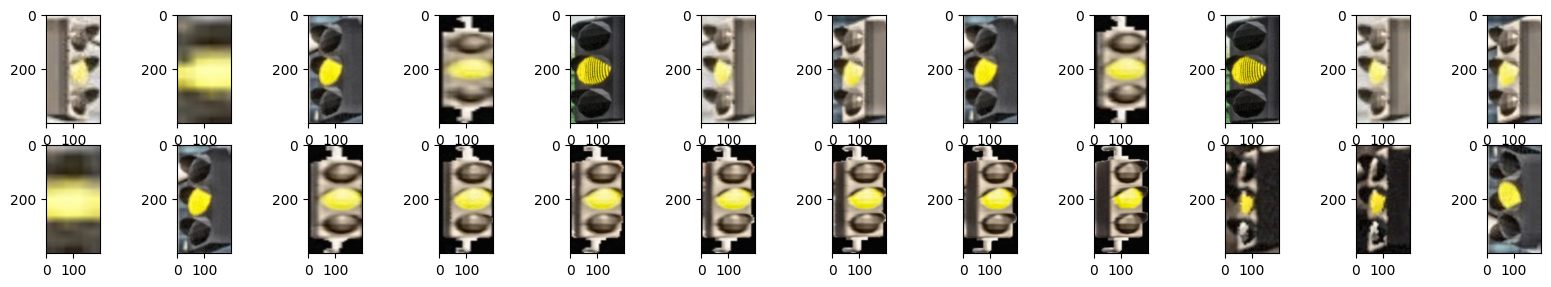

In [429]:
contrastYellow = contrastEnhancement(blurYellow)
displayImage(contrastYellow)

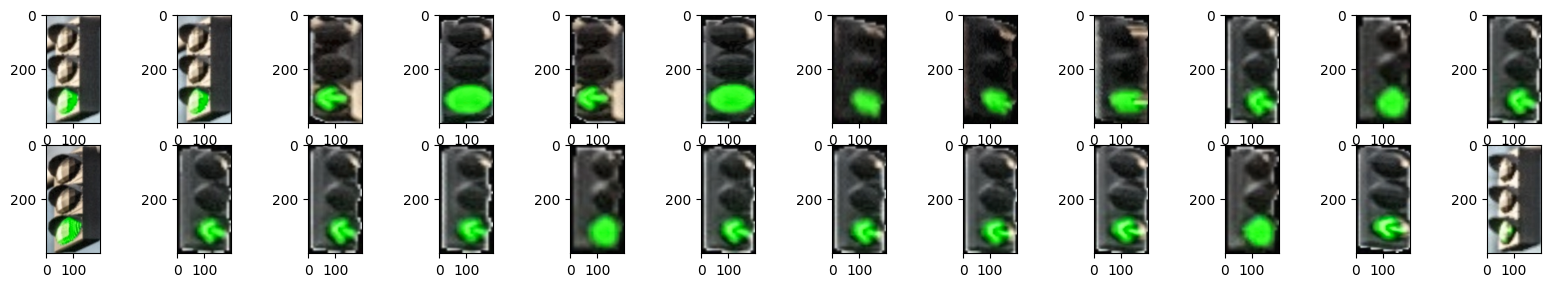

In [430]:
contrastGreen = contrastEnhancement(blurGreen)
displayImage(contrastGreen)

In [431]:
def saturationEnhancement(images):
    images_saturation = []
    for image in images:
        image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(image_hsv)
        saturation_factor = 1.5
        s = np.clip(s.astype(np.float32) * saturation_factor, 0, 255)
        s = np.clip(s, 0, 255).astype(np.uint8)
        image_hsv = cv2.merge([h, s, v])
        image_saturated = cv2.cvtColor(image_hsv, cv2.COLOR_HSV2BGR)
        images_saturation.append(image_saturated)
    return images_saturation


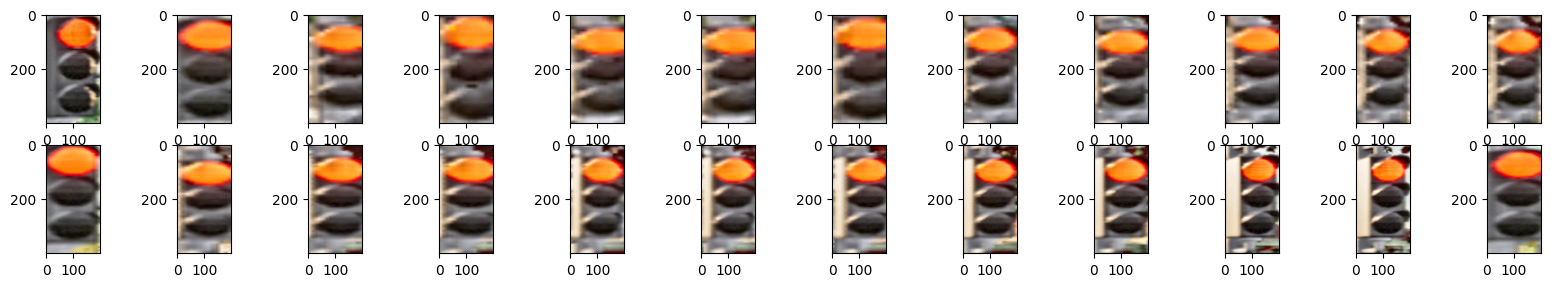

In [432]:
saturationRed = saturationEnhancement(contrastRed)
displayImage(saturationRed)

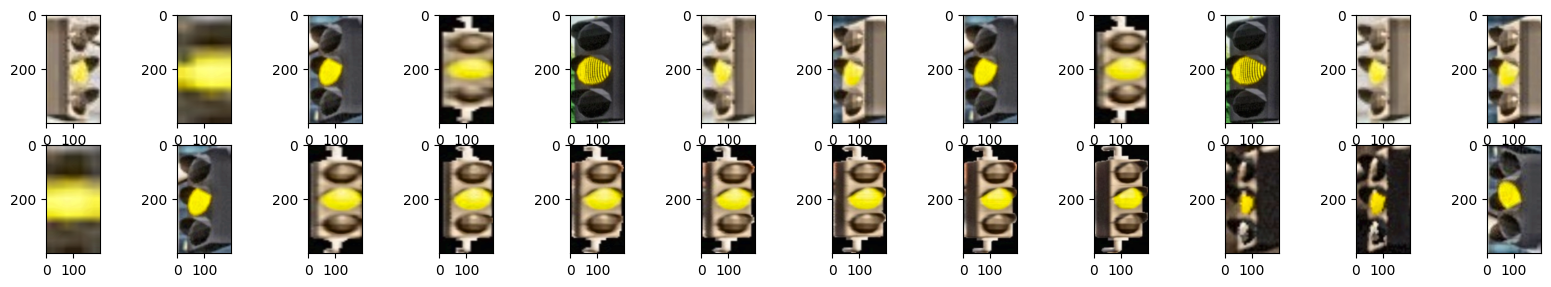

In [433]:
saturationYellow = saturationEnhancement(contrastYellow)
displayImage(saturationYellow)

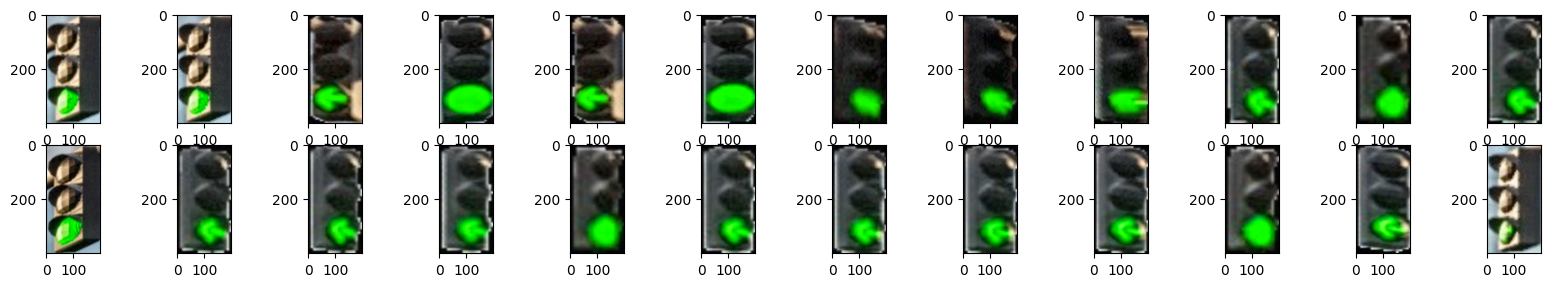

In [434]:
saturationGreen = saturationEnhancement(contrastGreen)
displayImage(saturationGreen)

In [435]:
def segmentColor(images):
    images_segment = []
    for image in images:
        image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        lower_red = np.array([0, 100, 20])
        upper_red = np.array([179, 255, 255])
        mask_red = cv2.inRange(image_hsv, lower_red, upper_red)
        lower_green = np.array([50, 100, 100])
        upper_green = np.array([70, 255, 255])
        mask_green = cv2.inRange(image_hsv, lower_green, upper_green)
        lower_yellow = np.array([20, 100, 100])
        upper_yellow = np.array([30, 255, 255])
        mask_yellow = cv2.inRange(image_hsv, lower_yellow, upper_yellow)
        mask = mask_red + mask_green + mask_yellow
        image_segment = cv2.bitwise_and(image, image, mask=mask)
        images_segment.append(image_segment)
    return images_segment



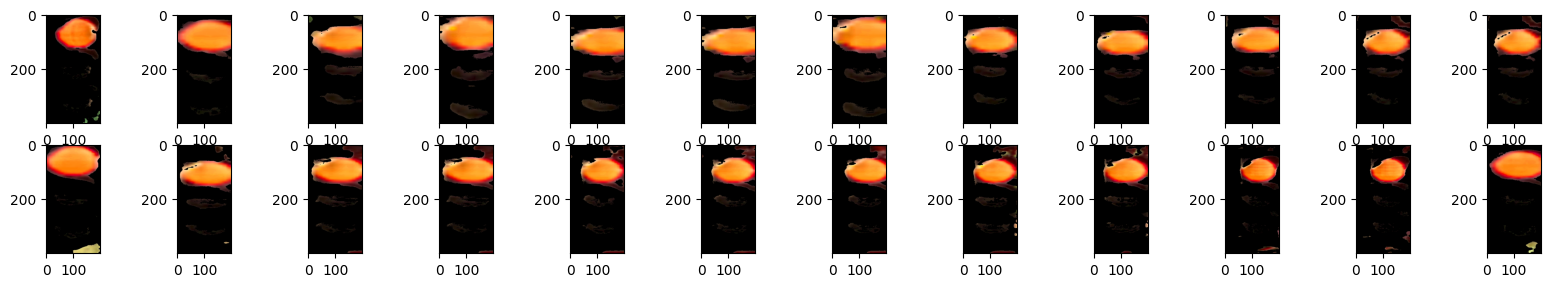

In [436]:
segmentRed = segmentColor(saturationRed)
displayImage(segmentRed)

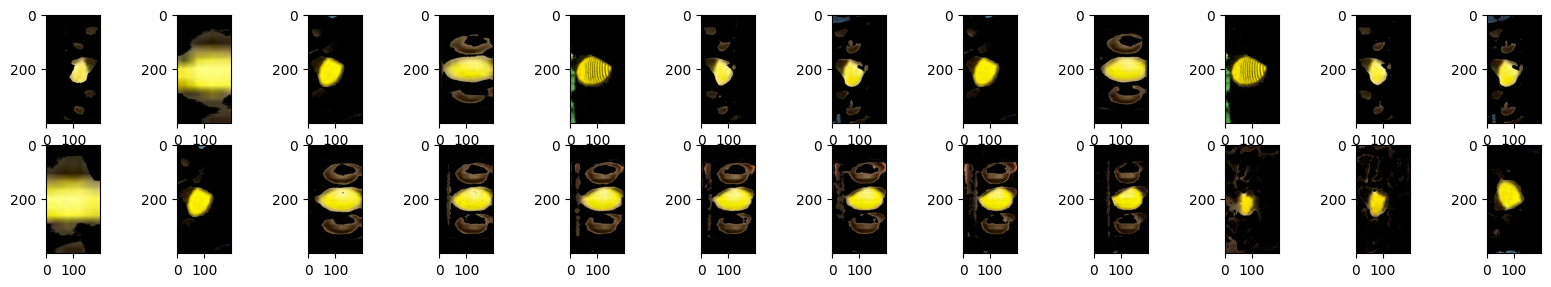

In [437]:
segmentYellow = segmentColor(saturationYellow)
displayImage(segmentYellow)

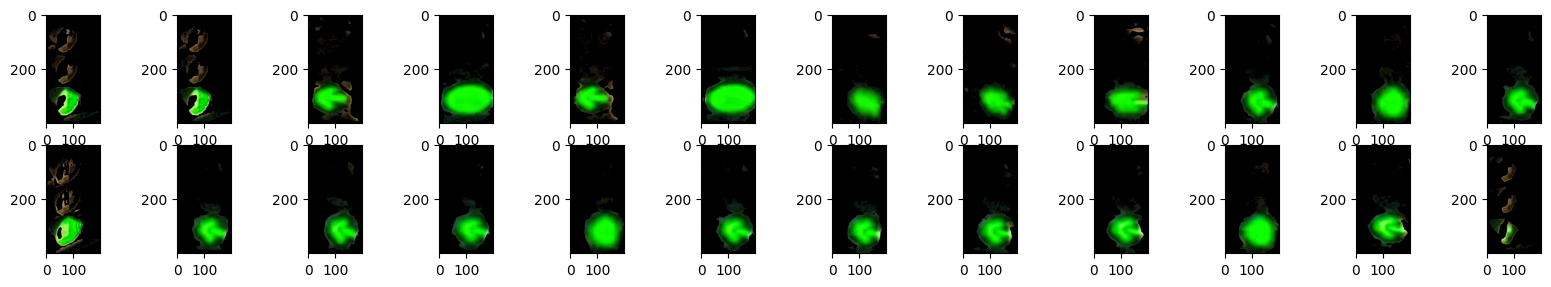

In [438]:
segmentGreen = segmentColor(saturationGreen)
displayImage(segmentGreen)

In [439]:
def erodeImage(images):
    images_erode = []
    kernel = np.ones((20, 20), np.uint8)
    for image in images:
        image_erode = cv2.erode(image, kernel, iterations=1)
        images_erode.append(image_erode)
    return images_erode

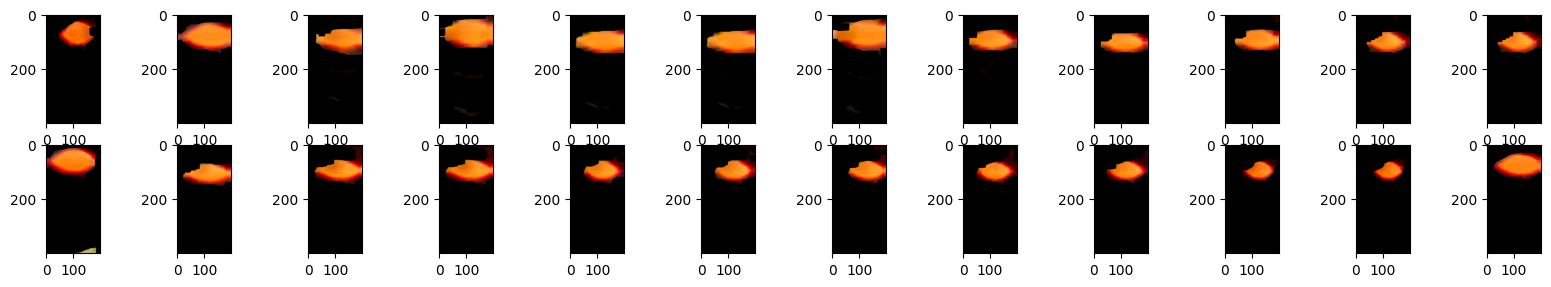

In [440]:
erodeRed = erodeImage(segmentRed)
displayImage(erodeRed)

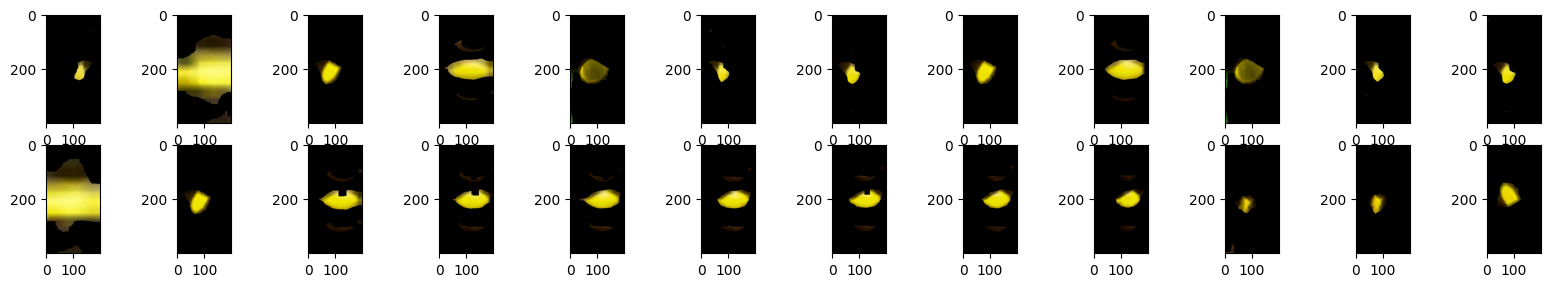

In [441]:
erodeYellow = erodeImage(segmentYellow)
displayImage(erodeYellow)

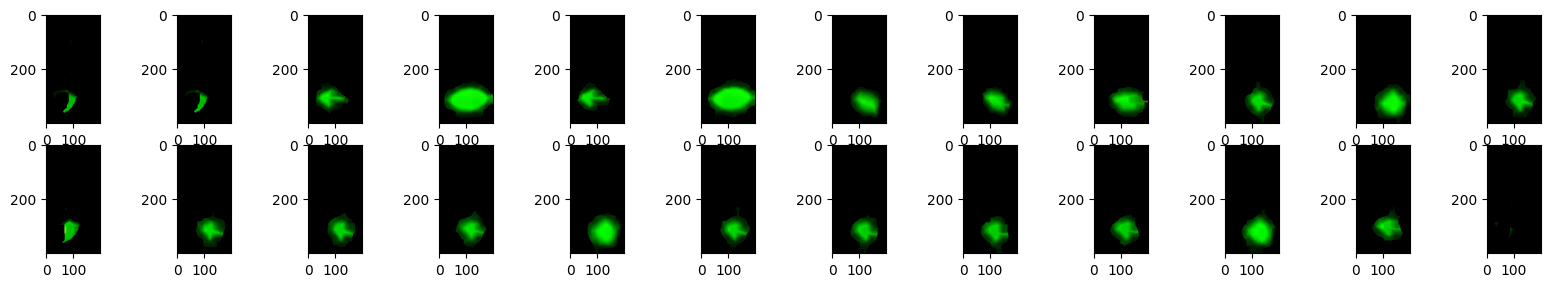

In [442]:
erodeGreen = erodeImage(segmentGreen)
displayImage(erodeGreen)

In [443]:
def recognizeTrafficLightColor(red_images, yellow_images, green_images):
    labels = [0, 1, 2]

    features = []
    target_labels = []

    for image in red_images:
        avg_color = np.mean(image, axis=(0, 1))
        features.append(avg_color)
        target_labels.append(labels[0])

    for image in yellow_images:
        avg_color = np.mean(image, axis=(0, 1))
        features.append(avg_color)
        target_labels.append(labels[1])

    for image in green_images:
        avg_color = np.mean(image, axis=(0, 1))
        features.append(avg_color)
        target_labels.append(labels[2])

    X_train, X_test, y_train, y_test = train_test_split(features, target_labels, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    model = KNeighborsClassifier(n_neighbors=3)
    model.fit(X_train, y_train)

    return model, scaler

In [444]:
model, scaler = recognizeTrafficLightColor(erodeRed, erodeYellow, erodeGreen)    

In [445]:
def allProcess(images):
    images_resize = resizeImage(images)
    images_noise = noiseRemoval(images_resize)
    images_contrast = contrastEnhancement(images_noise)
    images_saturation = saturationEnhancement(images_contrast)
    images_segment = segmentColor(images_saturation)
    images_erode = erodeImage(images_segment)
    return images_erode

In [503]:
def predictRandomTrafficLightColor(image, model, scaler):
    image = allProcess([image])[0]
    avg_color = np.mean(image, axis=(0, 1))
    scaled_color = scaler.transform([avg_color])
    predicted_label = model.predict(scaled_color)

    if predicted_label[0] == 0:
        return "red"
    elif predicted_label[0] == 1:
        return "yellow"
    elif predicted_label[0] == 2:
        return "green"

In [504]:
def randImage(folder):
    random_image = random.choice(os.listdir(folder))
    random_image_path = os.path.join(folder, random_image)
    random_image = cv2.imread(random_image_path)
    return random_image


Warna lampu lalu lintas:  green


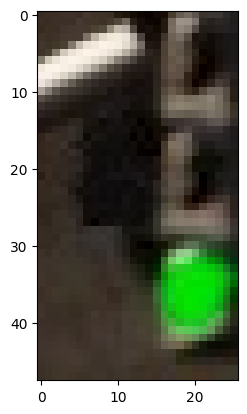

In [519]:
folder = ["red","yellow","green"]
folder_rand = random.choice(folder)
random_image = randImage(f"traffic_light_data/train/{folder_rand}/")
random_image = cv2.cvtColor(random_image, cv2.COLOR_BGR2RGB)
plt.imshow(random_image)
predicted_color = predictRandomTrafficLightColor(random_image, model, scaler)
print("Warna lampu lalu lintas: ", predicted_color)